# CIFAR10 - Deep Learning Workshop
Part 2 of assignment 1
---

This part contains transfer learning and features extraction

Some imports and important functions:

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from keras.datasets import cifar10
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.preprocessing import image
from keras.models import Model, Sequential, model_from_json
from keras.layers import Dense, Conv2D, Flatten, Input, AvgPool2D,MaxPool2D,Dropout,BatchNormalization
from keras.utils import to_categorical
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, VGG19, ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D, MaxPooling2D
from keras import optimizers
from keras.applications.vgg16 import preprocess_input as prep_input_vgg16
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from os.path import join
from sklearn.svm import SVC
from sklearn import tree

seed = 0
np.random.seed(seed)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#splitting test set to test+val sets for explicitly setting the validation data - x_train, y_train untouched
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)


def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].imshow(X[skip+i],cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='green' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    plt.show()

    
def plot_graphs(history):
  plt.subplot(2, 1 , 1)
  
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('validation accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  
  plt.subplot(2, 1 , 2)
  
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('validation loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  
#x_test must be appropriately normalized
def plot_conf_matrix(model, x_test, y_test):
  preds = model.predict(x_test)
  preds_cat = np.argmax(preds, axis=1)
  sns.heatmap(confusion_matrix(y_test, preds_cat), cmap='Greens', annot=True, fmt='d')
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title('Classification results on test set')
  return preds_cat
  
def plot_all(history, model, x_test, y_test):
  plot_graphs(history)
  preds_cat = plot_conf_matrix(model, x_test, y_test)
  
  acc_test = accuracy_score(y_test, preds_cat)*100
  acc_val = np.max(history.history['val_acc'])*100
  acc_train = np.max(history.history['acc'])*100
  
  dec = 3
  
  print('Model accuracy on test set is {}%'.format(np.around(acc_test, decimals=dec)))
  print('Model accuracy on validation set is {}%'.format(np.around(acc_val, decimals=dec)))
  print('Model accuracy on train set is {}%'.format(np.around(acc_train, decimals=dec)))
  
#define path in drive to save/read models to/from
models_path = '/content/drive/My Drive'

def save_model(model,filename):
    json_string = model.to_json()
    path = join(models_path, filename)
    open(path + '_architecture.json', 'w').write(json_string)
    model.save_weights(path + '_model_weights.h5', overwrite=True)
    
# this is a helper function used to restore a keras NN model architecture and weights
def read_model(filename):
    path = join(models_path, filename)
    model = model_from_json(open(path + '_architecture.json', 'r').read())
    model.load_weights(path + '_model_weights.h5')
    return model

def normalize_data(data):
  x_tr_mean, x_tr_std =  np.mean(data, axis = 0), np.std(data, axis = 0)  

  data_prep = (data - x_tr_mean) / x_tr_std
#   data_prep = data / 255.0
  return data_prep

Using TensorFlow backend.


170500096/170498071 [==============================] - 25s 0us/step


In [0]:
#Exploratory data analysis
print('Dataset size is: {} train and {} test examples, total {} examples.'.format(x_train.shape[0], x_test.shape[0], x_train.shape[0] + x_test.shape[0]))
print('The dimensions of an example is: {}'.format(x_train[0].shape))
print('Shape of y: {}'.format(y_train.shape))
y_val_cat = to_categorical(y_val)

Dataset size is: 50000 train and 10000 test examples, total 60000 examples.
The dimensions of an example is: (32, 32, 3)
Shape of y: (50000, 1)


# Transfer learning:


---
We implement transfer learning from the well known VGG16 model:


In [0]:
def transfer_try1():
  pt_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

  #freeze layers
  for layer in pt_model.layers:
      layer.trainable = False
      
  x_train_prep = prep_input_vgg16(x_train)
  
  #only changing the softmax layer to fit our problem - bad results
  x = Flatten()(pt_model.output)
  x = Dense(128, activation = 'relu')(x)
  x = Dense(128, activation = 'relu')(x)
  x = Dense(10, activation='softmax')(x)

  rdy_prep_model = Model(inputs = pt_model.input, outputs = x)
  rdy_prep_model.summary()

  #trying out optimizers
  sgd = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9, nesterov=True)
  rms = optimizers.RMSprop(lr=1e-4)
  adam = 'adam'

  rdy_prep_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

  history = rdy_prep_model.fit(x_train_prep, to_categorical(y_train), validation_split=0.2, shuffle=True, epochs=10)

  return history, rdy_prep_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

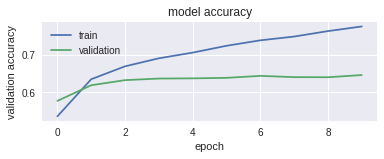

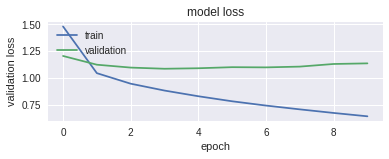

Model accuracy on test set is 35.73%
Model accuracy on validation set is 64.63%
Model accuracy on train set is 77.68%


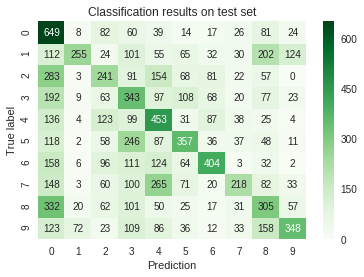

In [0]:
history, model = transfer_try1()
plot_all(history, model, x_test, y_test)

In [0]:
def transfer_try2():
  pt_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

  #freeze layers
  for layer in pt_model.layers[:11]:
      layer.trainable = False

  x_train_prep = normalize_data(x_train)
  x_tr, x_val, y_tr, y_val = train_test_split(x_train_prep, y_train, random_state=0) #default split size 0.25

  #prev layer is vgg16.output
  x = Flatten()(pt_model.get_layer('block3_pool').output)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(10, activation='softmax')(x)

  rdy_prep_model = Model(inputs = pt_model.input, outputs = x)
  rdy_prep_model.summary()

  #trying out optimizers
  sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  rms = optimizers.RMSprop(lr=1e-4)
  adam = 'adam'

  rdy_prep_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  history = rdy_prep_model.fit(x_tr, to_categorical(y_tr), validation_data=(x_val, to_categorical(y_val)), shuffle=True, epochs=25)

  return history, rdy_prep_model;


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

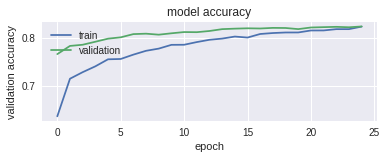

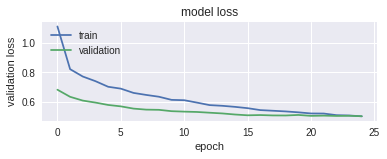

Model accuracy on test set is 82.05%
Model accuracy on validation set is 82.392%
Model accuracy on train set is 82.363%


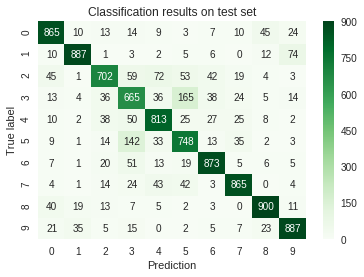

In [0]:
history, model = transfer_try2()
plot_all(history, model, normalize_data(x_test), y_test)

# Feature Extraction:

---



In [0]:
# Feature Extraction using Transfer Learning and traditional ML algorithms

def prepare_features(model):
  fe_layer_output = model.layers[-2].output
  features_model = Model(model.input, fe_layer_output)
  features_model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

  features_pred = features_model.predict(normalize_data(x_train))
  features_test = features_model.predict(normalize_data(x_test))
  
  return features_model, features_pred, features_test

def fit_feature_extraction(ml_model, modelname, features_pred, y_train, features_test, y_test):
  print('######### Testing {} Model #########'.format(modelname));
  
  ml_model.fit(features_pred, y_train.ravel())
  
  acc_train = ml_model.score(features_pred, y_train.ravel())*100
  acc_test = ml_model.score(features_test, y_test.ravel())*100
  
  print('Model accuracy on train set is {}%'.format(np.around(acc_train, decimals=3)));
  print('Model accuracy on test set is {}%'.format(np.around(acc_test, decimals=3)));
  
  print('####################################')

In [0]:
model = read_model('transfer_best')
features_model, features_pred, features_test = prepare_features(model)

In [0]:
# Logistic Regression

lr = LogisticRegression()
fit_feature_extraction(lr, 'Logistic Regression', features_pred, y_train, features_test, y_test)

######### Testing Logistic Regression Model #########
Model accuracy on train set is 93.33%
Model accuracy on test set is 82.01%
####################################


In [0]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=50, max_depth=6, criterion='entropy', min_samples_leaf=3)
fit_feature_extraction(random_forest, 'Random Forest', features_pred, y_train, features_test, y_test)

######### Testing Random Forest Model #########
Model accuracy on train set is 78.71%
Model accuracy on test set is 72.72%
####################################


In [0]:
# Decision Tree

decision_tree = tree.DecisionTreeClassifier(max_depth=20)
fit_feature_extraction(decision_tree, 'Decision Tree', features_pred, y_train, features_test, y_test)

######### Testing Decision Tree Model #########
Model accuracy on train set is 95.164%
Model accuracy on test set is 63.11%
####################################
